# Altogether Now
- rapid ML
- simple EDA (not even qlualify as one)
    - dropping most columns
    - simple imputer
- target, whether it is one-sided

## Libraries

In [1660]:
#general stuff
import os
import numpy as np
import pandas as pd

#Regular expression
import re

#Viz
import matplotlib.pyplot as plt
import seaborn as sns

#splittig data
from sklearn.model_selection import train_test_split

#imputer for missing values
from sklearn.impute import SimpleImputer

#pipeline
from sklearn.pipeline import Pipeline

#preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

#models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#GridSearchCV
from sklearn.model_selection import GridSearchCV

#cross validation
from sklearn.model_selection import cross_val_score

#confusion matrix
from sklearn.metrics import confusion_matrix

#classification_report
from sklearn.metrics import classification_report

#precision recall curve
from sklearn.metrics import precision_recall_curve

#roc curve
from sklearn.metrics import roc_curve

#auc score
from sklearn.metrics import roc_auc_score

#average_precision_score
from sklearn.metrics import average_precision_score

## Reading in the data

In [1661]:
#present working directory
pwd = os.getcwd()

#reading in train.csv
train = os.path.join(pwd, "raw_data/train.csv")
df_train = pd.read_csv(data)

#reading in test.csv
test = os.path.join(pwd, "raw_data/test.csv")
df_test = pd.read_csv(unseen)

#select PassengerId column for submission
test_ids = df_test["PassengerId"]

## Target Analysis
- survive and perish ratio
- to check whether it is on-sided

In [1662]:
df_train["Survived"].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

## Simple EDA
- only to 
    1. identify datatype
    2. locate missing values

In [1663]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [1664]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [1665]:
df_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Features and target selection
### Rapid feature selection
- 'PassengerId' -- drop (not related to survival)
- 'Survived'    -- drop (cos this is the target) 
- 'Pclass'      
- 'Name'        -- drop (title might be related tho.)
- 'Sex'
- 'Age' 
- 'SibSp'
- 'Parch' 
- 'Ticket'      -- drop (Ticket number less likely to affect survival)
- 'Fare' 
- 'Cabin'       -- drop (cos >77% na, i.e. 687/891) 
- 'Embarked'
### Datatype to categorical
- for filesize reduction
- faster output in later processing
### Datatype of Target to int

In [1666]:
features = df_train.drop(
    ["PassengerId","Survived","Name","Ticket","Cabin"], axis=1
)
target = df_train[["Survived"]]

In [1667]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [1668]:
# for col in ['parks', 'playgrounds', 'sports', 'roading']:
#     public[col] = public[col].astype('category')

for col in ["Pclass", "Sex", "SibSp","Parch", "Embarked"]:
    features[col] = features[col].astype("category")

for col in ["Age", "Fare"]:
    features[col] = features[col].astype("float")

In [1669]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    891 non-null    category
 1   Sex       891 non-null    category
 2   Age       714 non-null    float64 
 3   SibSp     891 non-null    category
 4   Parch     891 non-null    category
 5   Fare      891 non-null    float64 
 6   Embarked  889 non-null    category
dtypes: category(5), float64(2)
memory usage: 19.5 KB


In [1670]:
target = target.astype("int")
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


## Splitting Data

### Feature (derived from train.csv) will split into 3 to develop a model:
- **Training Set (X_train, y_train):**  To build the model
- **Validation Set (X_val, y_val):**    To select the parameters of the model
- **Test Set (X_test, y_test):**        To evaluate the performace of selected parameters

In [1671]:
#trainval (train + validaiton) & test dataset 
X_trainval, X_test, y_trainval, y_test = train_test_split(features, target, random_state=42, stratify=target)

X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=42, stratify=y_trainval)

## Preprocessing and Pipeline

In [1672]:
categorical = ["Pclass", "Sex","Embarked"]
numerical = ["Age","SibSp", "Parch", "Fare"]

#two pipelines to handle categorical and numeric data
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

#transform and concatenate features
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_pipe", cat_pipe, categorical),
        ("num_pipe", num_pipe, numerical)
    ]
)

#combine preprocessing and classifier together
pipe = Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("classifier", SVC())
    ]
)

# # sanity check for preprocessing
# a = preprocessor.fit_transform(X_train, y_train)
# pd.DataFrame(a).head()

### Accessing steps in pipeline

In [1673]:
pipe.steps[0][1]

ColumnTransformer(transformers=[('cat_pipe',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Pclass', 'Sex', 'Embarked']),
                                ('num_pipe',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'SibSp', 'Parch', 'Fare'])])

## Grid Search and CV

In [1674]:
#classifier and parameters

param_grid = [
    #svc
    {
        "classifier":[SVC()],
        "preprocessor":[preprocessor],
        "classifier__C":[0.01, 0.1, 1, 10, 100,1000],
        "classifier__gamma":[100,10,1,0.1,0.01,0.001]
        # [0.001, 0.01, 0.1, 1, 10, 100,1000]
    },
    #knn
    {
        "classifier":[KNeighborsClassifier()],
        "preprocessor":[preprocessor],
        "classifier__n_neighbors":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    },
    #logreg
    {
        "classifier":[LogisticRegression()],
        "preprocessor":[preprocessor],
        "classifier__C":[0.001, 0.01, 0.1, 1, 10, 100]
    }
]

In [1675]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_trainval, np.ravel(y_trainval))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Embarked']),
  

In [1676]:
print(
    "Test-set score: {:5f}\n".format(grid.score(X_test, y_test))
)
print(
    "Best cross-validaiton score: {:.5f}".format(grid.best_score_)
)
print(
    "Best params:\n{}\n".format(grid.best_params_)
)
print(
    "Best best_estimator_: {}".format(grid.best_estimator_)
)

Test-set score: 0.802691

Best cross-validaiton score: 0.83532
Best params:
{'classifier': SVC(C=10, gamma=0.1), 'classifier__C': 10, 'classifier__gamma': 0.1, 'preprocessor': ColumnTransformer(transformers=[('cat_pipe',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Pclass', 'Sex', 'Embarked']),
                                ('num_pipe',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'SibSp', 'Parch'

## Justification of parameters

- Whether each classifier used the most optimal parameters to achieve the highest accuracy (.score)

In [1677]:
gridsearchcv_results = pd.DataFrame(grid.cv_results_)
# sanity check
# gridsearchcv_results["param_classifier"].unique

In [1678]:
#convert dtype of column param_classifier from object to string
#dtype will appear as oject but in face changed to string
gridsearchcv_results['param_classifier'] = gridsearchcv_results['param_classifier'].astype('str') 

In [1679]:
svc_max_score = filter_is_svc["mean_test_score"].max()
knn_max_score = filter_is_knn["mean_test_score"].max()
logreg_max_score = filter_is_logreg["mean_test_score"].max()
print(
    "accuracy comparison:"
)
print(
   "svc maximum accuracy:       {:.5f}".format(svc_max_score)
)
print(
   "knn maximum accuracy:       {:.5f}".format(knn_max_score)
)
print(
   "logreg maximum accuracy:    {:.5f}".format(logreg_max_score)
)

accuracy comparison:
svc maximum accuracy:       0.83532
knn maximum accuracy:       0.83387
logreg maximum accuracy:    0.80994


### SVC()

In [1680]:
is_svc = gridsearchcv_results['param_classifier'].str.contains("SVC")
filter_is_svc = gridsearchcv_results[is_svc]

Text(0.5, 1.0, 'SVC - GridSearchCV Heatmap')

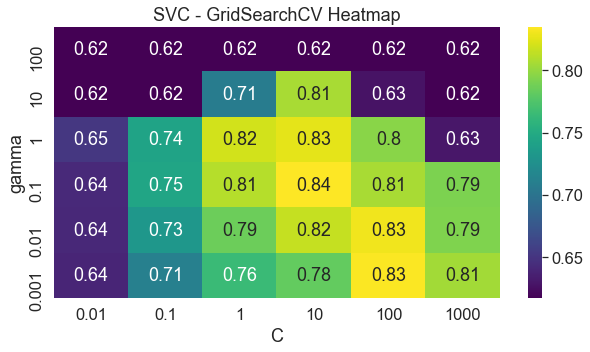

In [1681]:
mean_test_score = np.array(filter_is_svc["mean_test_score"]).reshape(6,6)

plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

sns.heatmap(
    mean_test_score,
    annot=True,
    cmap="viridis",
    xticklabels=param_grid[0]["classifier__C"],
    yticklabels=param_grid[0]["classifier__gamma"]
)

#titles, x,y-labels
plt.xlabel("C")
plt.ylabel("gamma")
plt.title("SVC - GridSearchCV Heatmap")

### KNN

In [1682]:
#filter knn
is_knn = gridsearchcv_results["param_classifier"]=="KNeighborsClassifier()"
filter_is_knn = gridsearchcv_results[is_knn]

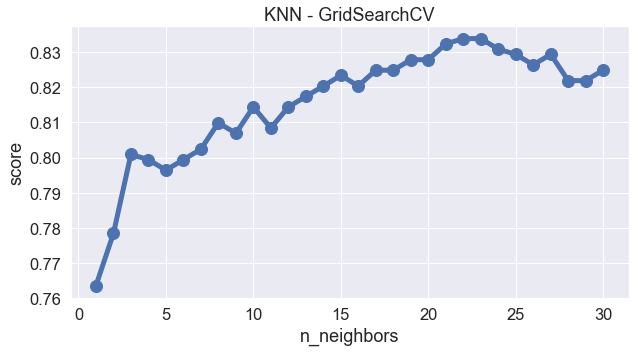

In [1683]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

plt.plot(
    filter_is_knn["param_classifier__n_neighbors"],
    filter_is_knn["mean_test_score"],
    linewidth=5,
    marker="o",
    markersize=12
)

plt.xlabel("n_neighbors")
plt.ylabel("score")
plt.title("KNN - GridSearchCV")
plt.show()

### Logistic Regression

In [1684]:
#filter logreg
is_logreg = gridsearchcv_results["param_classifier"]=="LogisticRegression()"
filter_is_logreg = gridsearchcv_results[is_logreg]

Text(0.5, 1.0, 'Logreg - GridSearchCV')

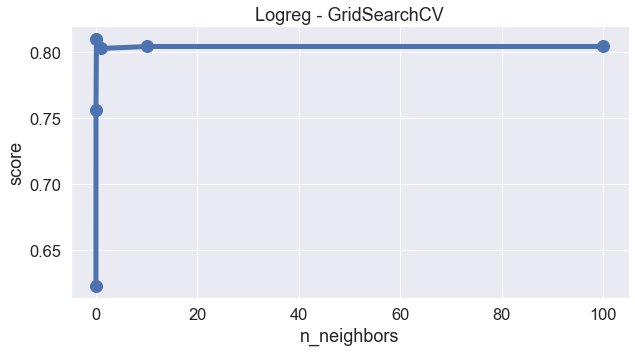

In [1685]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

plt.plot(
    filter_is_logreg["param_classifier__C"],
    filter_is_logreg["mean_test_score"],
    linewidth=5,
    marker="o",
    markersize=12
)

plt.xlabel("n_neighbors")
plt.ylabel("score")
plt.title("Logreg - GridSearchCV")

In [1686]:
# nested = cross_val_score(
#     GridSearchCV(pipe, param_grid=param_grid, cv=5),
#     features, np.ravel(target), cv=5
# )
# nested.mean()

## Confusion Matrix

In [1687]:
X_train_fit_trans = preprocessor.fit_transform(X_train)
X_test_fit_trans = preprocessor.transform(X_test)


In [1688]:
svc = SVC(C=10, gamma=0.1)
svc.fit(X_train_fit_trans, np.ravel(y_train))
pred_svc = svc.predict(X_test_fit_trans)
confusion_svc = confusion_matrix(y_test, pred_svc)

knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train_fit_trans, np.ravel(y_train))
pred_knn = knn.predict(X_test_fit_trans)
confusion_knn = confusion_matrix(y_test, pred_knn)

logreg = LogisticRegression(C=0.1)
logreg.fit(X_train_fit_trans, np.ravel(y_train))
pred_logreg = logreg.predict(X_test_fit_trans)
confusion_logreg = confusion_matrix(y_test, pred_logreg)

In [1689]:
print(
    "\n\nsvc\n",
    confusion_svc,
    "\n\nknn\n",
    confusion_knn,
    "\n\nlogreg\n",
    confusion_logreg
)



svc
 [[118  19]
 [ 28  58]] 

knn
 [[123  14]
 [ 30  56]] 

logreg
 [[117  20]
 [ 29  57]]


In [1690]:
target_names=['dead','survived']

print(
    "SVC\n",
    classification_report(y_test, pred_svc, target_names=target_names)
)
print(
    "KNN\n",
    classification_report(y_test, pred_knn, target_names=target_names)
)
print(
    "Logreg\n",
    classification_report(y_test, pred_logreg, target_names=target_names)
)

SVC
               precision    recall  f1-score   support

        dead       0.81      0.86      0.83       137
    survived       0.75      0.67      0.71        86

    accuracy                           0.79       223
   macro avg       0.78      0.77      0.77       223
weighted avg       0.79      0.79      0.79       223

KNN
               precision    recall  f1-score   support

        dead       0.80      0.90      0.85       137
    survived       0.80      0.65      0.72        86

    accuracy                           0.80       223
   macro avg       0.80      0.77      0.78       223
weighted avg       0.80      0.80      0.80       223

Logreg
               precision    recall  f1-score   support

        dead       0.80      0.85      0.83       137
    survived       0.74      0.66      0.70        86

    accuracy                           0.78       223
   macro avg       0.77      0.76      0.76       223
weighted avg       0.78      0.78      0.78       223



### Precision Recall Curve

In [1691]:
#SVC
ap_svc = average_precision_score(y_test,svc.decision_function(X_test_fit_trans))
#KNN
ap_knn = average_precision_score(y_test, knn.predict_proba(X_test_fit_trans)[:,1])
#Logreg
ap_logreg = average_precision_score(y_test, logreg.decision_function(X_test_fit_trans))

In [1692]:
print(
    "Average precision of svc:     {:.3f}".format(ap_svc)
)
print(
    "Average precision of knn:     {:.3f}".format(ap_knn)
)
print(
    "Average precision of logreg:  {:.3f}".format(ap_logreg)
)

Average precision of svc:     0.765
Average precision of knn:     0.772
Average precision of logreg:  0.781


Text(0.5, 1.0, 'Precision Recall Curve')

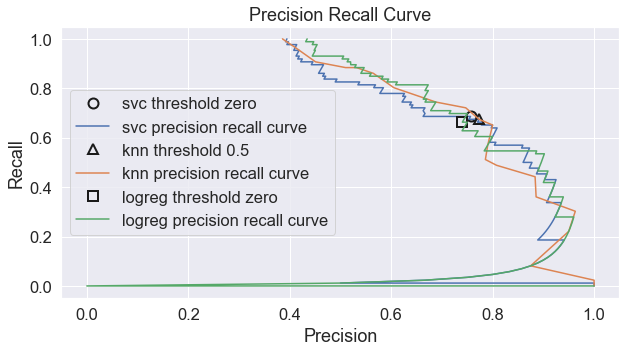

In [1693]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

#svc
precision_svc, recall_svc, thresholds_svc = precision_recall_curve(y_test, svc.decision_function(X_test_fit_trans))

close_zero_svc = np.argmin(np.abs(thresholds_svc))

plt.plot(precision_svc[close_zero_svc], recall_svc[close_zero_svc], "o", markersize=10, label="svc threshold zero",fillstyle="none", c="k", mew=2)

plt.plot(precision_svc, recall_svc, label="svc precision recall curve")

#knn
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_test, knn.predict_proba(X_test_fit_trans)[:,1])

close_zero_knn = np.argmin(np.abs(thresholds_knn - 0.5))

plt.plot(precision_knn[close_zero_knn], recall_knn[close_zero_knn], "^", markersize=10, label="knn threshold 0.5",fillstyle="none", c="k", mew=2)

plt.plot(precision_knn, recall_knn, label="knn precision recall curve")

#logreg
precision_logreg, recall_logreg, thresholds_logreg = precision_recall_curve(y_test, logreg.decision_function(X_test_fit_trans))

close_zero_logreg = np.argmin(np.abs(thresholds_logreg))

plt.plot(precision_logreg[close_zero_logreg], recall_logreg[close_zero_logreg], "s", markersize=10, label="logreg threshold zero",fillstyle="none", c="k", mew=2)

plt.plot(precision_logreg, recall_logreg, label="logreg precision recall curve")

#labels
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")
plt.title("Precision Recall Curve")

### ROC AUC curves

In [1694]:
# svc_auc = roc_auc_score(y_test, svc.decision_function(X_test_fit_trans))

svc_auc = roc_auc_score(y_test, svc.decision_function(X_test_fit_trans))
knn_auc = roc_auc_score(y_test, knn.predict_proba(X_test_fit_trans)[:,1])
logreg_auc = roc_auc_score(y_test, logreg.decision_function(X_test_fit_trans))

In [1695]:
print(
    "AUC for SVC:    {:.3f}".format(svc_auc)
)
print(
    "AUC for KNN:    {:.3f}".format(knn_auc)
)
print(
    "AUC for Logreg: {:.3f}".format(logreg_auc)
)

AUC for SVC:    0.803
AUC for KNN:    0.823
AUC for Logreg: 0.841


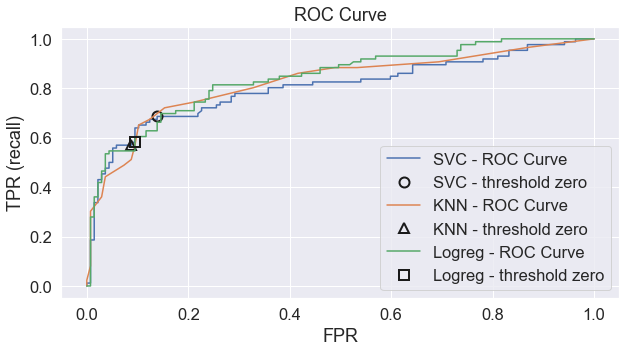

In [1696]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

#svc
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, svc.decision_function(X_test_fit_trans))

plt.plot(fpr_svc, tpr_svc, label="SVC - ROC Curve")


close_zero_svc = np.argmin(np.abs(thresholds_svc))

plt.plot(fpr_svc[close_zero_svc],tpr_svc[close_zero_svc],"o", markersize=10,label="SVC - threshold zero", fillstyle="none", c="k", mew=2)

#knn
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test,  knn.predict_proba(X_test_fit_trans)[:,1])

plt.plot(fpr_knn, tpr_knn, label="KNN - ROC Curve")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("KNN - ROC Curve")

close_zero_knn = np.argmin(np.abs(thresholds_knn))

plt.plot(fpr_svc[close_zero_knn],tpr_svc[close_zero_knn],"^", markersize=10,label="KNN - threshold zero", fillstyle="none", c="k", mew=2)

#logreg
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test,  logreg.decision_function(X_test_fit_trans))

plt.plot(fpr_logreg, tpr_logreg, label="Logreg - ROC Curve")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("Logreg - ROC Curve")

close_zero_logreg = np.argmin(np.abs(thresholds_logreg))

plt.plot(fpr_svc[close_zero_logreg],tpr_svc[close_zero_logreg],"s", markersize=10,label="Logreg - threshold zero", fillstyle="none", c="k", mew=2)


plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("ROC Curve")
plt.legend(loc="best")



# fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test_fit_trans))

# plt.plot(fpr, tpr, label="SVC - ROC Curve")

# plt.xlabel("FPR")
# plt.ylabel("TPR (recall)")
# plt.title("SVC - ROC Curve")

# close_zero_svc = np.argmin(np.abs(thresholds))

# plt.plot(fpr[close_zero_svc],tpr[close_zero_svc],"o", markersize=10,label="SVC - threshold zero", fillstyle="none", c="k", mew=2)
# plt.legend(loc="best")

## Submission

In [1697]:
# features = train_filled.drop(
#     ["PassengerId","Survived","Name","Ticket","Cabin"], axis=1
# )
# target = train_filled[["Survived"]]

test_features = df_test.drop(
    ["PassengerId","Name","Ticket","Cabin"], axis=1
)
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


In [1698]:
for col in ["Pclass", "Sex", "SibSp","Parch", "Embarked"]:
    test_features[col] = features[col].astype("category")

for col in ["Age", "Fare"]:
    test_features[col] = features[col].astype("float")

In [1699]:
test_features.shape

(418, 7)

In [1710]:
train_features_trans = preprocessor.fit_transform(features)
test_features_trans = preprocessor.transform(test_features)

In [1712]:
clf = SVC(C=10, gamma=0.1)
clf.fit(train_features_trans, np.ravel(target))

SVC(C=10, gamma=0.1)

In [1713]:
submission_pred = clf.predict(test_features_trans)

In [1714]:
df_submit = pd.DataFrame(
    {
    "PassengerId":test_ids.values,
    "Survived":submission_pred
    }
)

In [1716]:
df_submit.to_csv("submission/submission-20210602.csv", index=False)